# Final Project
### Hanlin Liu  02081102

---------------------------


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from scipy.integrate import solve_ivp
from tqdm import tqdm
# plotting preferences updates
colors = ['#132A36', '#780627','#4692BD', '#079069']

# Set plotting parameters
params = {'figure.figsize': (6.0,6.0),
          'axes.labelsize': 16,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'legend.fontsize': 12,
          'font.size': 12
           }

plt.rcParams.update(params)
rng = np.random.default_rng(0)

--------------

## Part 1
### Question 1

In [4]:
# function of Lu-Chen System
def Lu_Chen(t, X, a, b, c, u):
    x,y,z = X
    dx = -a*x + a*y
    dy = -x*z + c*y + x + u
    dz = x*y -b*z
    return [dx,dy,dz]

In [5]:
# Set parameters
delta = 0.001 # small perturbation
ic = [1.0,1.0,1.0] # initial condition
ic_per = [1.0+delta, 1.0, 1.0] # initial condition with perturbation
a,b,c,u = [25.20, 3.00, 20.30, -15.14] # system parameter

# time step
h=0.001 
# time span for the simulation
t_span = (0,20)
t_eval = np.arange(t_span[0], t_span[1]+0.1*h, h)

# solution of the simulation for initial condition
sol = solve_ivp(Lu_Chen, t_span, ic, t_eval=t_eval, args = (a,b,c,u))
x1,y1,z1 = sol.y
t = sol.t

# solution of the simulation for initial condition with perturbation
sol_per = solve_ivp(Lu_Chen, t_span, ic_per, t_eval=t_eval, args = (a,b,c,u))
x2, y2, z2 = sol_per.y


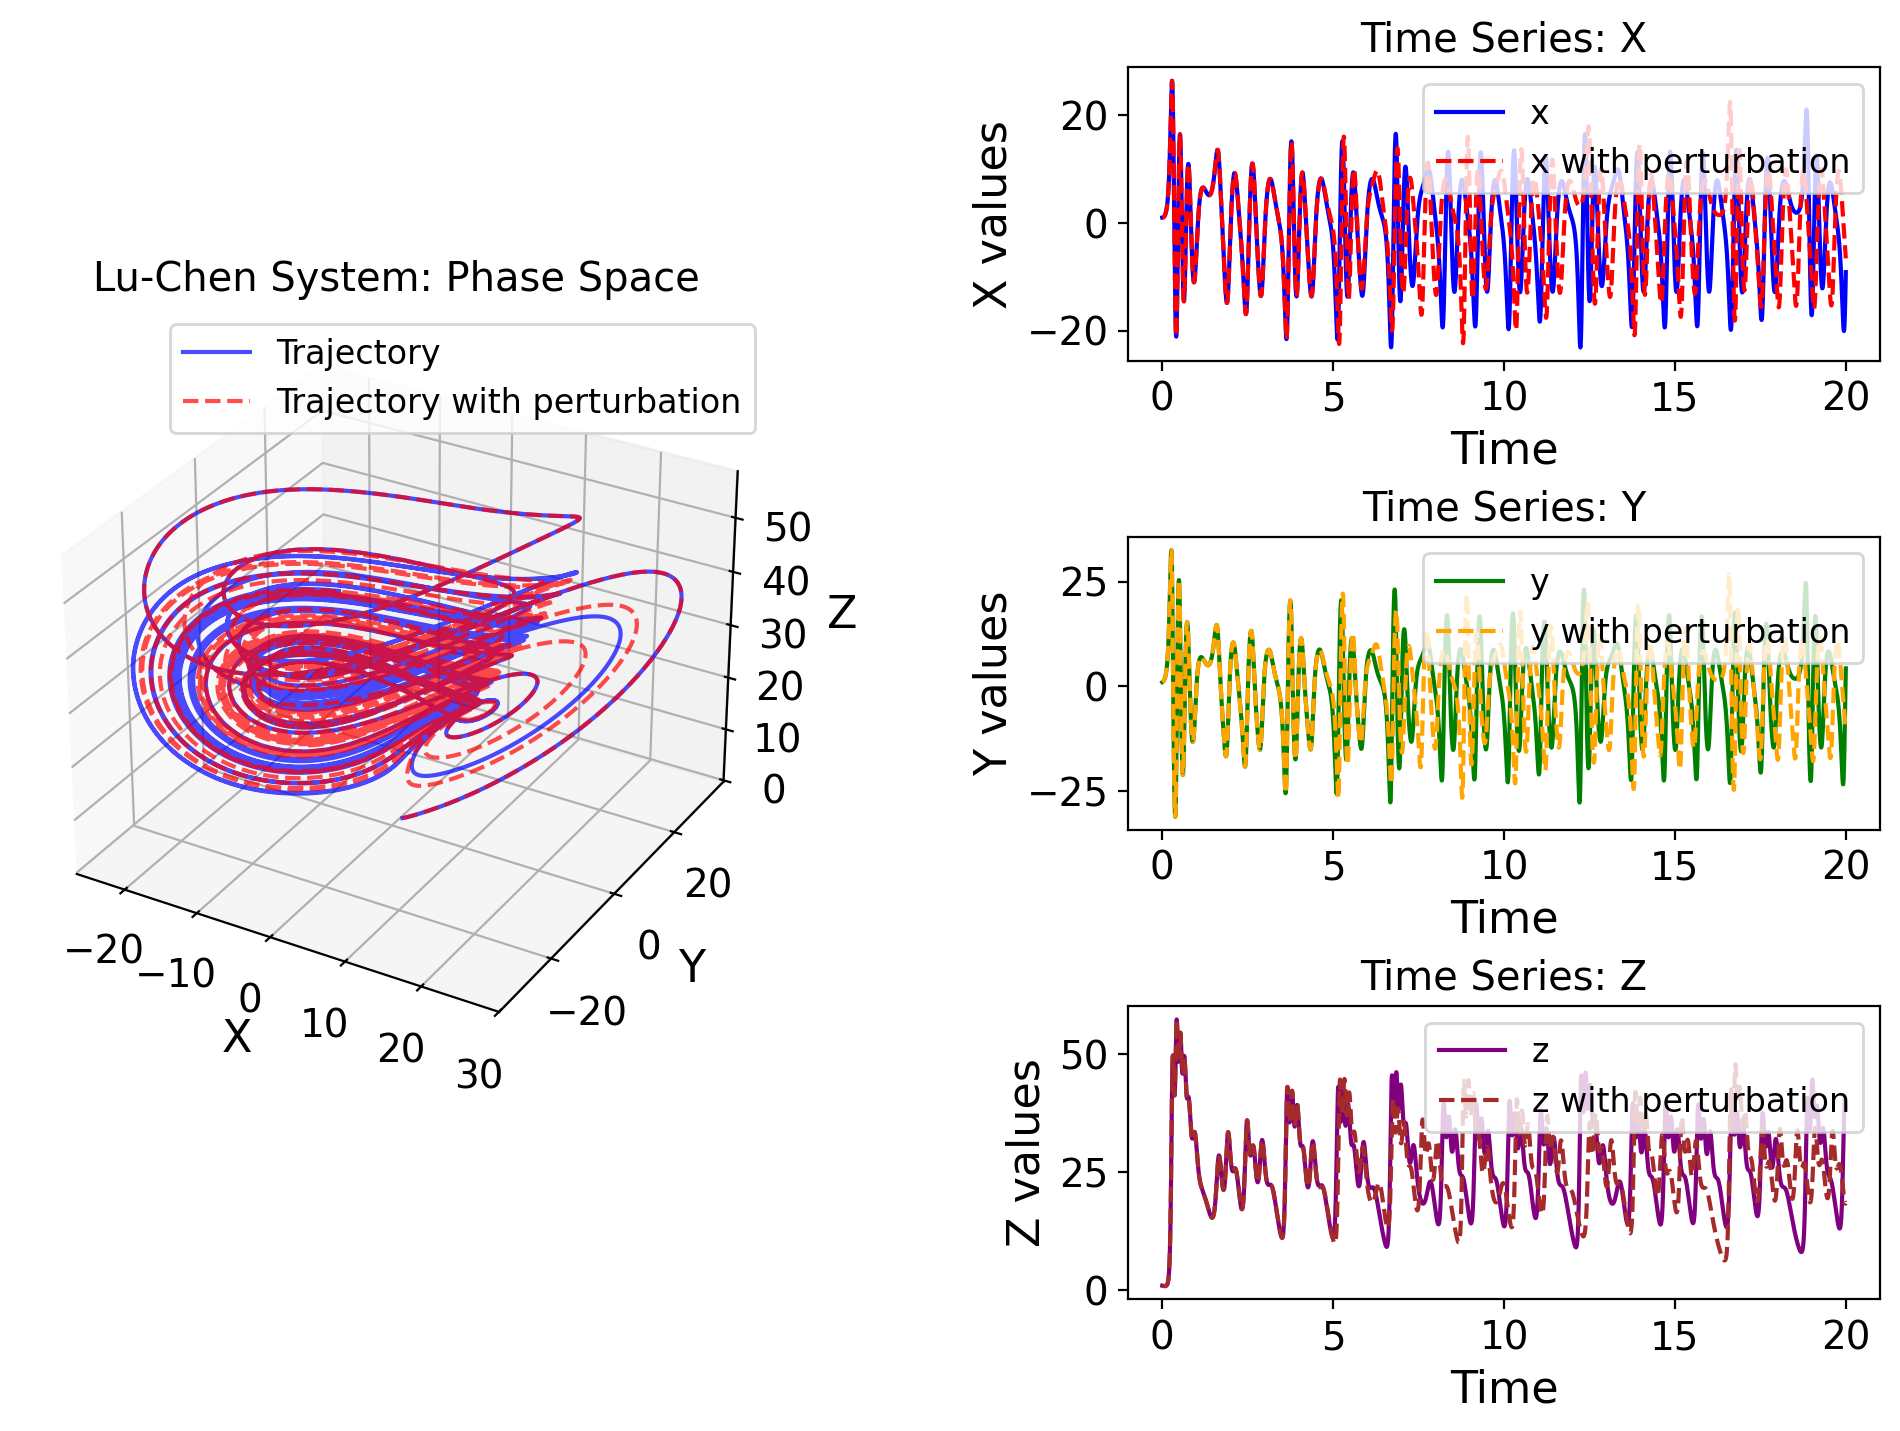

In [6]:
# Create a figure with a GridSpec layout
fig = plt.figure(figsize=(12, 8))
grid = fig.add_gridspec(3, 7, wspace=0.4, hspace=0.6)

# 3D Phase Space Plot (Occupying first 3x3 space)
ax1 = fig.add_subplot(grid[:3, :3], projection='3d')
ax1.plot(x1, y1, z1, label="Trajectory", color='blue', alpha=0.7)
ax1.plot(x2, y2, z2, label="Trajectory with perturbation", color='red', linestyle='dashed', alpha=0.7)
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_title("Lu-Chen System: Phase Space")
ax1.legend()

# Time Series Plots
# X vs Time (Occupying 1 row, 3 columns)
ax2 = fig.add_subplot(grid[0, 4:])
ax2.plot(t, x1, label="x", color='blue')
ax2.plot(t, x2, label="x with perturbation", color='red', linestyle='dashed')
ax2.set_xlabel("Time")
ax2.set_ylabel("X values")
ax2.set_title("Time Series: X")
ax2.legend()

# Y vs Time (Occupying 1 row, 3 columns)
ax3 = fig.add_subplot(grid[1, 4:])
ax3.plot(t, y1, label="y", color='green')
ax3.plot(t, y2, label="y with perturbation", color='orange', linestyle='dashed')
ax3.set_xlabel("Time")
ax3.set_ylabel("Y values")
ax3.set_title("Time Series: Y")
ax3.legend()

# Z vs Time (Occupying 1 row, 3 columns)
ax4 = fig.add_subplot(grid[2, 4:])
ax4.plot(t, z1, label="z", color='purple')
ax4.plot(t, z2, label="z with perturbation", color='brown', linestyle='dashed')
ax4.set_xlabel("Time")
ax4.set_ylabel("Z values")
ax4.set_title("Time Series: Z")
ax4.legend()

plt.show()

The small perturbation did not cause big difference at the beginning (aroud 5 seconds). But as the time evolves, two initial conditions will form two totally different trajectories. This means Lu-Chen system is very sensitive to the initial condition when time gets large.

### Question 2

In [9]:
# Gram-Schmidt reorthogonalization function
def gram_schmidt(vectors):
    dim = vectors.shape[1]
    ortho_vectors = np.copy(vectors)
    norms = np.zeros(dim)

    for i in range(dim):
        for j in range(i):
            proj = np.dot(ortho_vectors[:, j], ortho_vectors[:, i]) * ortho_vectors[:, j]
            ortho_vectors[:, i] -= proj
        norms[i] = np.linalg.norm(ortho_vectors[:, i])
        ortho_vectors[:, i] /= norms[i]

    return ortho_vectors, norms

# Lyapunov spectrum calculation
def lyap_exp(f, dim, params, t_span, t_step, dt, x_0, transient=100):
    t_start, t_end = t_span
    timesteps = int(round((t_end - t_start) / t_step))
    y = np.hstack((x_0, np.eye(dim).flatten()))  # State + tangent vectors
    cum = np.zeros(dim)
    t = t_start

    # Integration and reorthogonalization loop
    for _ in range(timesteps):
        sol = solve_ivp(f, [t, t + t_step], y, args=(params,), max_step=dt)
        y = sol.y[:, -1]

        # Extract tangent vectors and reorthogonalize using Gram-Schmidt
        tangent_vectors = y[dim:].reshape(dim, dim).T
        ortho_vectors, norms = gram_schmidt(tangent_vectors)
        y[dim:] = ortho_vectors.T.flatten()

        # Accumulate logarithms of norms
        if t > transient:
            cum += np.log(norms)

        t += t_step

    # Return average Lyapunov exponents
    return cum / (t_end - t_start - transient)

# Function of the system given with the Jacobian matrix
def Lu_Chen_Jac(t, X, params):
    x, y, z = X[:3]
    Y = X[3:].reshape(3, 3).T
    a,b,c,u = params
    f = np.zeros(12)
    f[:3] = [-a*x+a*y, -x*z+c*y+x+u, x*y-b*z]
    Jac = np.array([[-a, a, 0],
                    [1-z, c, -x],
                    [y, x, -b]])
    f[3:] = (Jac @ Y).T.flatten()
    return f

In [10]:
# Set parameters
params = [25.20, 3.00, 20.30, -15.14] # Coefficients
X0 = [1.0, 1.0, 1.0]  # Initial condition
t_span = (0, 1000)  # Time span for integration
t_step = 0.1  # Integration step size
dt = 0.001  # Maximum step size
transient = 100  # Transient time to discard

# Storage for Lyapunov spectra
lyapunov_spectra = []

L = lyap_exp(Lu_Chen_Jac, dim=3, t_span=t_span, t_step=t_step, dt=dt, x_0=X0, params=params, transient=transient)
lyapunov_spectra.append(L)

# Convert results to a numpy array for easy manipulation
lyapunov_spectra = np.array(lyapunov_spectra)

print(f'The Lyapunov exponents for system with parameter a={params[0]}, b={params[1]}, c={params[2]}, u={params[3]} is',lyapunov_spectra)

The Lyapunov exponents for system with parameter a=25.2, b=3.0, c=20.3, u=-15.14 is [[ 1.31878868e+00  2.86617142e-04 -9.21819752e+00]]


1. The **largest Lyapunov exponent (LLE)** is **positive** , so the system is in a chaotic regime.
2. The **second** exponent is close to **zero**, representing motion along the attractor.
3. The **third exponent** is **negative**, indicating contraction to the attractor.

In [12]:
# values for a
a_values = np.arange(23, 36+0.01, 0.1)

# Storage for Lyapunov spectra
lyapunov_spectra = []

# Sweep `a` and calculate Lyapunov spectra
for a in tqdm(a_values, desc="Sweeping parameter a"):
    params = (a, 3.00, 20.30, -15.14) # parameters for each iteration
    L = lyap_exp(Lu_Chen_Jac, dim=3, t_span=t_span, t_step=t_step, 
                 dt=dt, x_0=X0, params=params, transient=transient)
    lyapunov_spectra.append(L)

# Convert results to a numpy array for easy manipulation
lyapunov_spectra = np.array(lyapunov_spectra)

Sweeping parameter a: 100%|██████████| 131/131 [4:40:53<00:00, 128.65s/it]  


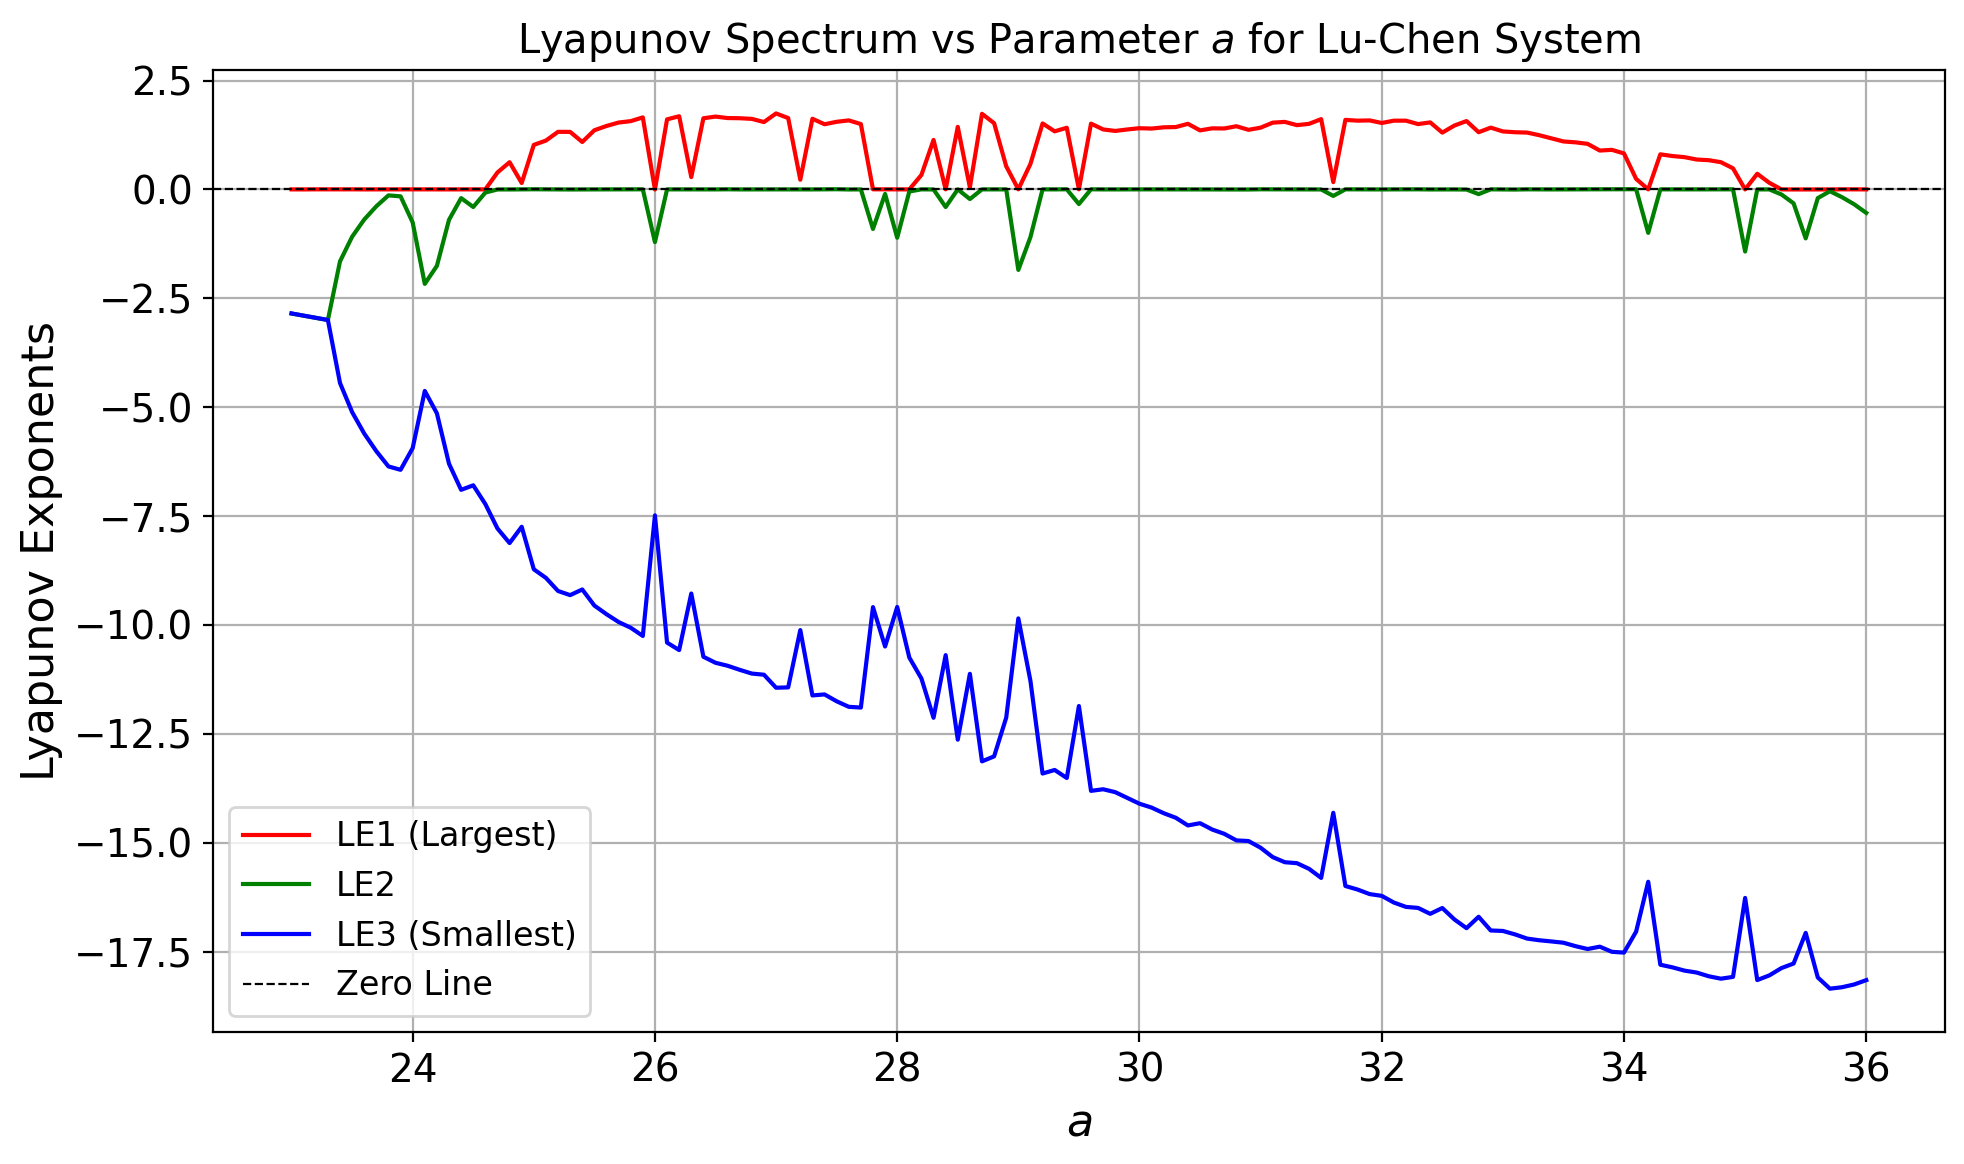

In [13]:
# Plotting the Lyapunov spectrum as a function of `a`
plt.figure(figsize=(10, 6))
plt.plot(a_values, lyapunov_spectra[:, 0], label='LE1 (Largest)', color='r')
plt.plot(a_values, lyapunov_spectra[:, 1], label='LE2', color='g')
plt.plot(a_values, lyapunov_spectra[:, 2], label='LE3 (Smallest)', color='b')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--', label='Zero Line')
plt.xlabel('$a$')
plt.ylabel('Lyapunov Exponents')
plt.title('Lyapunov Spectrum vs Parameter $a$ for Lu-Chen System')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This graph shows how Lyapunov exponents changes with $a$. If the largest Lyapunov exponent is less than zero, we are in the periodic regimes. If LLE is greater than zero, then we are in the chaotic regimes.

### Question 3

In [16]:
# time step
h=0.001
# time span for the simulation
t_span = (0,1000)
t_eval = np.arange(t_span[0], t_span[1], h)

# compute bifurcation points by using Poincare Sections
bifurcation_data = []
for a in tqdm(a_values, desc="Sweeping parameter a"):
    # simulations
    sol_a = solve_ivp(Lu_Chen, t_span, ic, t_eval=t_eval, args=(a, b, c, u))
    x,y,z = sol_a.y
    t = sol_a.t
    # Remove transient (first 10% of the time)
    transient_cutoff = int(len(t) * 0.1)
    x, y, z, t = x[transient_cutoff:], y[transient_cutoff:], z[transient_cutoff:], t[transient_cutoff:]

    # Find accurate Poincaré section crossings using interpolation
    trajectory = []
    for i in range(len(t) - 1):
        if x[i] < 0 and x[i + 1] > 0:  # Detect zero crossing (x ≈ 0)
            # Linear interpolation for better accuracy
            t_cross = t[i] - (x[i] / (x[i + 1] - x[i])) * (t[i + 1] - t[i])
            y_cross = y[i] + (y[i + 1] - y[i]) * (t_cross - t[i]) / (t[i + 1] - t[i]) # only track crossings in y
            trajectory.append((a, y_cross))
    bifurcation_data.extend(trajectory)
bifurcation_data = np.array(bifurcation_data)



Sweeping parameter a: 100%|██████████| 131/131 [06:43<00:00,  3.08s/it]


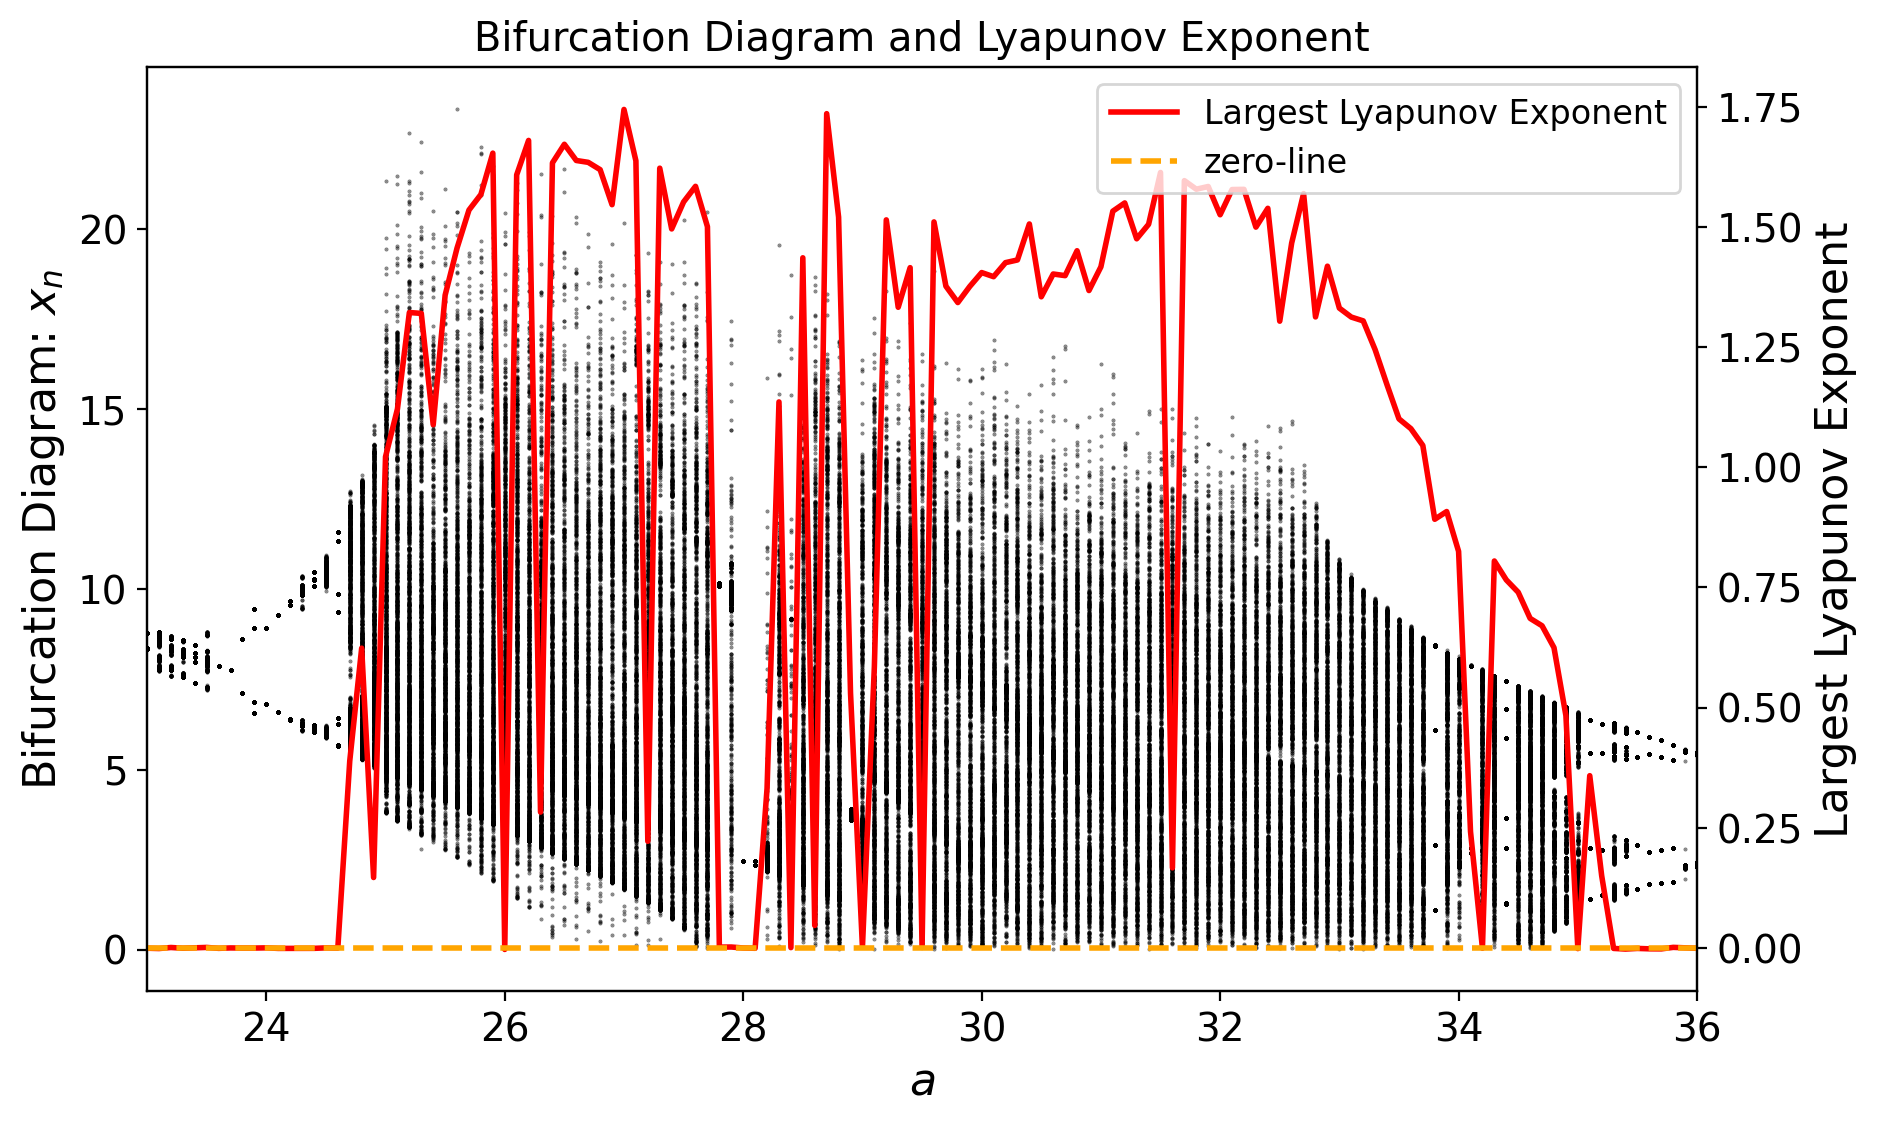

In [17]:
# Plot bifurcation diagram and Lyapunov exponent together
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bifurcation diagram
ax1.scatter(bifurcation_data[:, 0], bifurcation_data[:, 1], s=0.2, color="black", alpha=0.5)
ax1.set_xlabel("$a$")
ax1.set_ylabel("Bifurcation Diagram: $x_n$")
ax1.set_xlim([23,36])
ax1.set_title("Bifurcation Diagram and Lyapunov Exponent")

# largest Lyapunov exponent plot (secondary y-axis)
ax2 = ax1.twinx()
ax2.plot(a_values, lyapunov_spectra[:, 0], color="red", linewidth=2, label="Largest Lyapunov Exponent")
ax2.axhline(0, color='orange', linestyle="dashed", linewidth=2, label="zero-line")  # Zero reference line
ax2.set_ylabel("Largest Lyapunov Exponent")
ax2.legend(loc="upper right")

plt.show()

This bifurcation diagram aligns with the largest Lyapunov exponent in general. There is some difference around $a=34$. This may be because our step is too small. When LLE is across zero, there is a transition between periodic and chaotic regimes. This is also shown in the bifurcation diagram. If we are in some periodic regimes, the vertical points will stay in a specific position(s). On the other hand, if we are in some chaotic regimes, the points will be dense in the vertical line.

----------------

## Part 2
### Question 1

The idea for this question is to reconstruct $y$ by using synchronization. To do this, we can simply add a x-coupled function $y_{transmit}-y$ to $dy/dt$ with coupling term.

In [20]:
# function to simulate Bob's system
def Lu_Chen_Bob(t, X, params, alpha, s):
    a,b,c,u = params
    x,y,z = X
    dx = -a*x + a*y
    dy = -x*z + c*y + x + u + alpha*(s-y) # coupling function
    dz = x*y -b*z
    return [dx,dy,dz]

In [21]:
# coupling term
alpha = 10
# initial condition for Alice's system
ic = [0.1,0.1,0.1]
# parameters for Alice's system
a,b,c,u = [25.20, 3.00, 20.30, -15.14]

# time step
h=0.001
# tiem span
t_span = (0,20)
t_eval = np.arange(t_span[0], t_span[1]+0.1*h, h)

# simulation of Alice's system
sol = solve_ivp(Lu_Chen, t_span, ic, t_eval=t_eval, args = (a,b,c,u))
x,y,z = sol.y
t = sol.t
# add message and noise
message = 0.1 * np.sin((1.2 * np.pi * np.sin(t))**2) * np.cos(10*np.pi*np.cos(0.9*t))/np.pi/(np.sin(t))**2  #message
noise = rng.normal(0,0.01,len(t)) # noise
y_transmit = y + message + noise # Masked signal

# recovery of y
y_rs = [ic[1]] 
# initial point
x_r, y_r, z_r = ic 
# parameters
params = [a,b,c,u]
# simulation for Bob's system
for i in range(1, len(t)):
    t_step = [t[i - 1], t[i]] # time span for each step
    sol_r = solve_ivp(Lu_Chen_Bob, t_step, [x_r, y_r, z_r], args=(params, alpha, y_transmit[i]))
    x_r, y_r, z_r = sol_r.y[:, -1]  # update point
    y_rs.append(y_r)  # store y only

C:\Users\Henley\AppData\Local\Temp\ipykernel_4940\3177136039.py:19: RuntimeWarning: invalid value encountered in divide
  message = 0.1 * np.sin((1.2 * np.pi * np.sin(t))**2) * np.cos(10*np.pi*np.cos(0.9*t))/np.pi/(np.sin(t))**2  #message


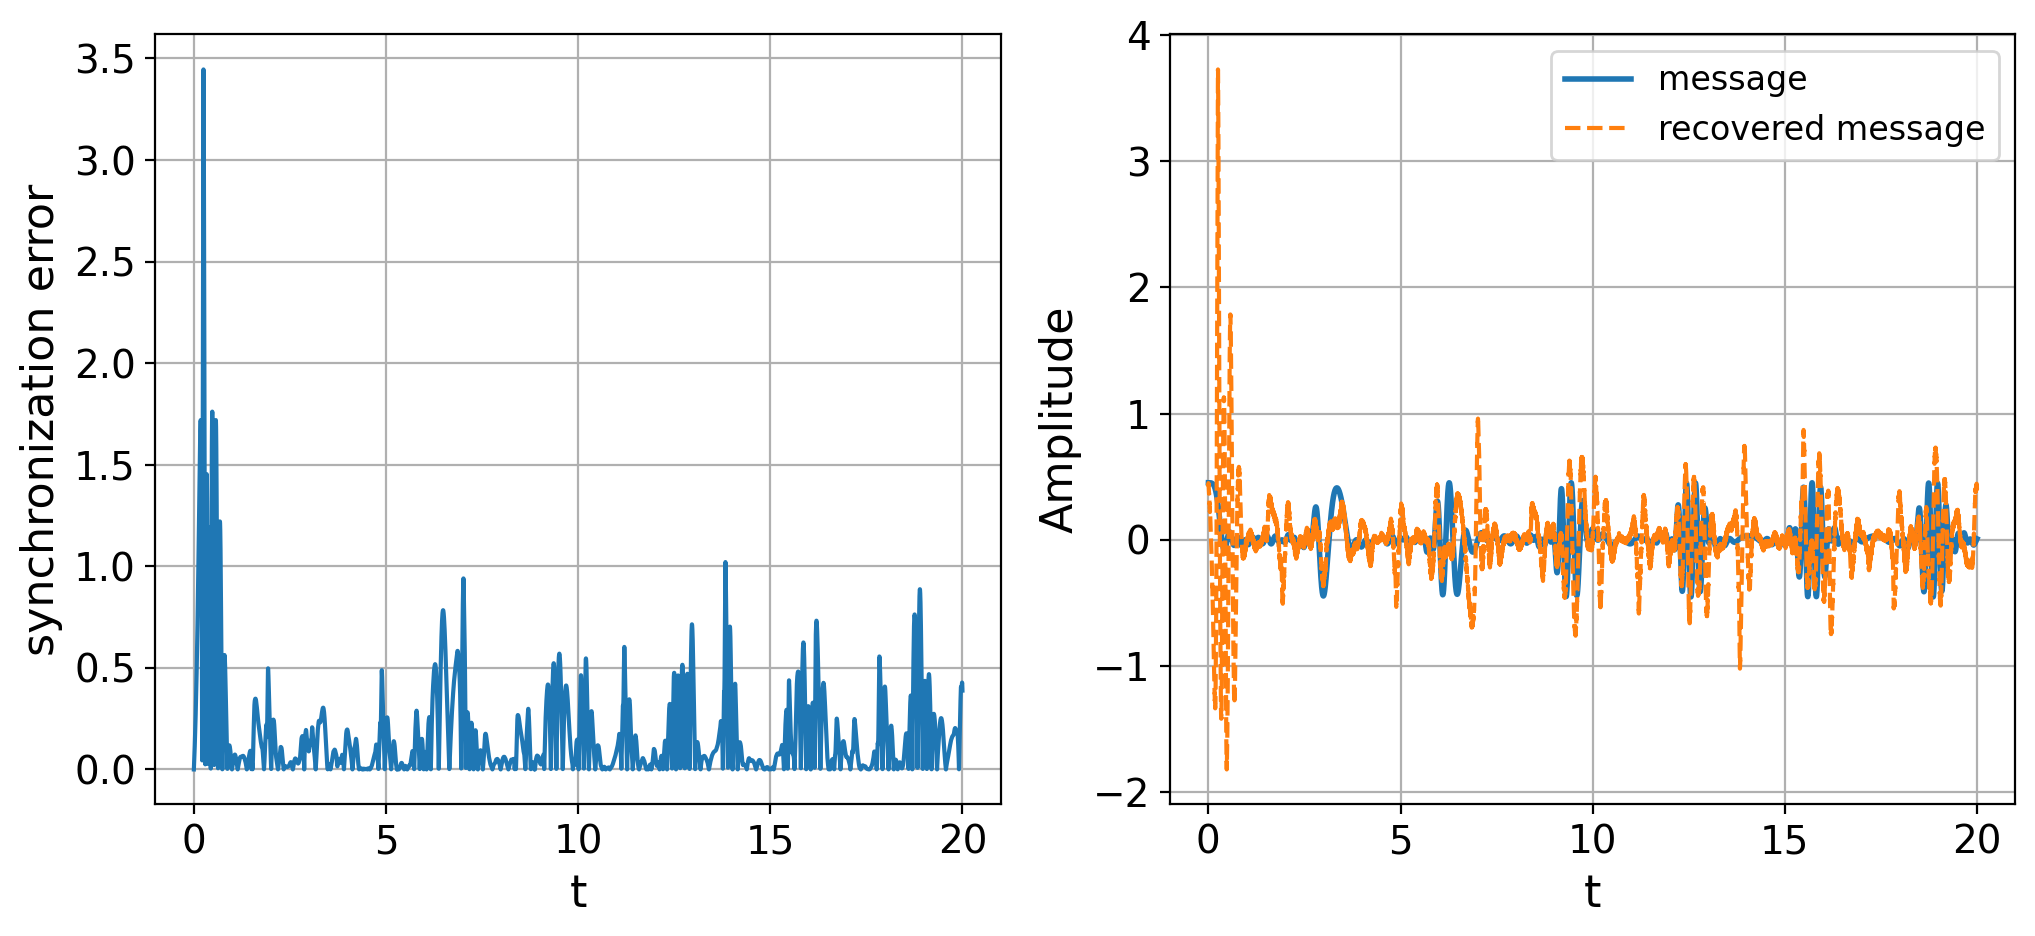

In [22]:
# synchronization error
err = np.abs(y_rs-y)
# reconstructed message
m_r = y_transmit-y_rs

# plot synchronization error and recovered messages
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(t, err)
plt.xlabel('t')
plt.ylabel('synchronization error')
plt.grid()

fig.add_subplot(122)
plt.plot(t_eval, message,linewidth=2, label='message')
plt.plot(t_eval, m_r, '--', label='recovered message')
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.show()

The left figure shows that the difference in y of the two systems does synchronize except in some places where the message exists. The right figure shows that the recovered message does share some structure with the original message. However, some unwanted noises are not in the original message. Fortunately, these noises do not influence the message itself.

### Question 2

The idea is to build a library including all state variables and use `Sindy` method to reconstruct equations. In the end, the reconstructed equation of 5 nodes should share the same system plus some coupling functions. 

In [24]:
# load the data
data = np.loadtxt('network_dynamics_data.txt')
t=data[:,0]
X = data[:,1:]

# compute the derivative of data
dt=t[1]-t[0]
dX_dt = np.gradient(data[:,1:], dt, axis=0)

# Polynomial basis library
def build_library(X):
    x1, y1, z1 = X[:,0], X[:,1], X[:,2]
    x2, y2, z2 = X[:,3], X[:,4], X[:,5]
    x3, y3, z3 = X[:,6], X[:,7], X[:,8]
    x4, y4, z4 = X[:,9], X[:,10], X[:,11]
    x5, y5, z5 = X[:,12], X[:,13], X[:,14]
    return np.column_stack([
        np.ones(len(x1)), x1, y1, z1, x1*y1, x1*z1, y1*z1, x1**2, y1**2, z1**2,
        x2, y2, z2, x2*y2, x2*z2, y2*z2, x2**2, y2**2, z2**2,
        x3, y3, z3, x3*y3, x3*z3, y3*z3, x3**2, y3**2, z3**2,
        x4, y4, z4, x4*y4, x4*z4, y4*z4, x4**2, y4**2, z4**2,
        x5, y5, z5, x5*y5, x5*z5, y5*z5, x5**2, y5**2, z5**2
    ])

A = build_library(X)

# Sindy method
def sindy(A,y):
    x = np.linalg.pinv(A) @ y
    for _ in range(10):
        small = np.abs(x) < 0.01
        x[small] = 0
        if np.any(~small):
            x[~small] = np.linalg.pinv(A[:, ~small]) @ y
    return x

# Solve for each component separately
coeffs = np.column_stack([
    sindy(A, dX_dt[:, i]) for i in range(15)
])

# Display reconstructed equations
feature_names = ['1', 'x1', 'y1', 'z1', 'x1y1', 'x1z1', 'y1z1', 'x1²', 'y1²', 'z1²',
                'x2', 'y2', 'z2', 'x2y2', 'x2z2', 'y2z2', 'x2²', 'y2²', 'z2²',
                'x3', 'y3', 'z3', 'x3y3', 'x3z3', 'y3z3', 'x3²', 'y3²', 'z3²',
                'x4', 'y4', 'z4', 'x4y4', 'x4z4', 'y4z4', 'x4²', 'y4²', 'z4²',
                'x5', 'y5', 'z5', 'x5y5', 'x5z5', 'y5z5', 'x5²', 'y5²', 'z5²']

variables = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3',
            'x4', 'y4', 'z4', 'x5', 'y5', 'z5']
for idx, var in enumerate(variables): 
    terms = [f"({c:.3f}){f}" for c, f in zip(coeffs[:, idx], feature_names) if abs(c) > 0.1]
    equation = f"d{var}/dt = {' + '.join(terms)}"
    print(equation)

dx1/dt = (-26.509)x1 + (25.011)y1 + (0.501)x2 + (0.500)x3 + (0.501)x4
dy1/dt = (-17.784)1 + (-0.717)x1 + (21.118)y1 + (0.448)z1 + (-0.944)x1z1
dz1/dt = (1.556)1 + (-0.718)x1 + (0.425)y1 + (-3.082)z1 + (0.999)x1y1
dx2/dt = (0.501)x1 + (-25.503)x2 + (25.005)y2
dy2/dt = (-14.427)1 + (0.450)x2 + (20.322)y2 + (-0.978)x2z2
dz2/dt = (0.433)1 + (-3.045)z2 + (0.995)x2y2
dx3/dt = (0.501)x1 + (-25.506)x3 + (25.009)y3
dy3/dt = (-14.275)1 + (-0.108)x3 + (20.651)y3 + (-0.960)x3z3
dz3/dt = (0.627)1 + (-3.068)z3 + (0.998)x3y3
dx4/dt = (0.500)x1 + (-26.010)x4 + (25.012)y4 + (0.501)x5
dy4/dt = (-18.358)1 + (-1.602)x4 + (21.814)y4 + (0.478)z4 + (-0.912)x4z4 + (-0.430)x5 + (0.438)y5
dz4/dt = (2.684)1 + (-1.372)x4 + (0.935)y4 + (-3.093)z4 + (1.001)x4y4 + (-0.666)x5 + (0.542)y5
dx5/dt = (0.501)x4 + (-25.508)x5 + (25.009)y5
dy5/dt = (-13.202)1 + (-0.616)x5 + (20.971)y5 + (-0.944)x5z5
dz5/dt = (1.351)1 + (-0.480)x4 + (0.340)y4 + (-0.578)x5 + (0.350)y5 + (-3.093)z5 + (0.999)x5y5


Notice that these equations are quite similar to Lu-Chen system with coupling function $x_j-x_i$ added on $dx_i/dt$ and $i\neq j$. The problem is, some additional terms are not in Lu-Chen system. But notice that when this happens, the constant term will change a lot. Maybe we can ignore these term and find a suitable constant term to make every equation the same. But before that, let's see how these equations work.

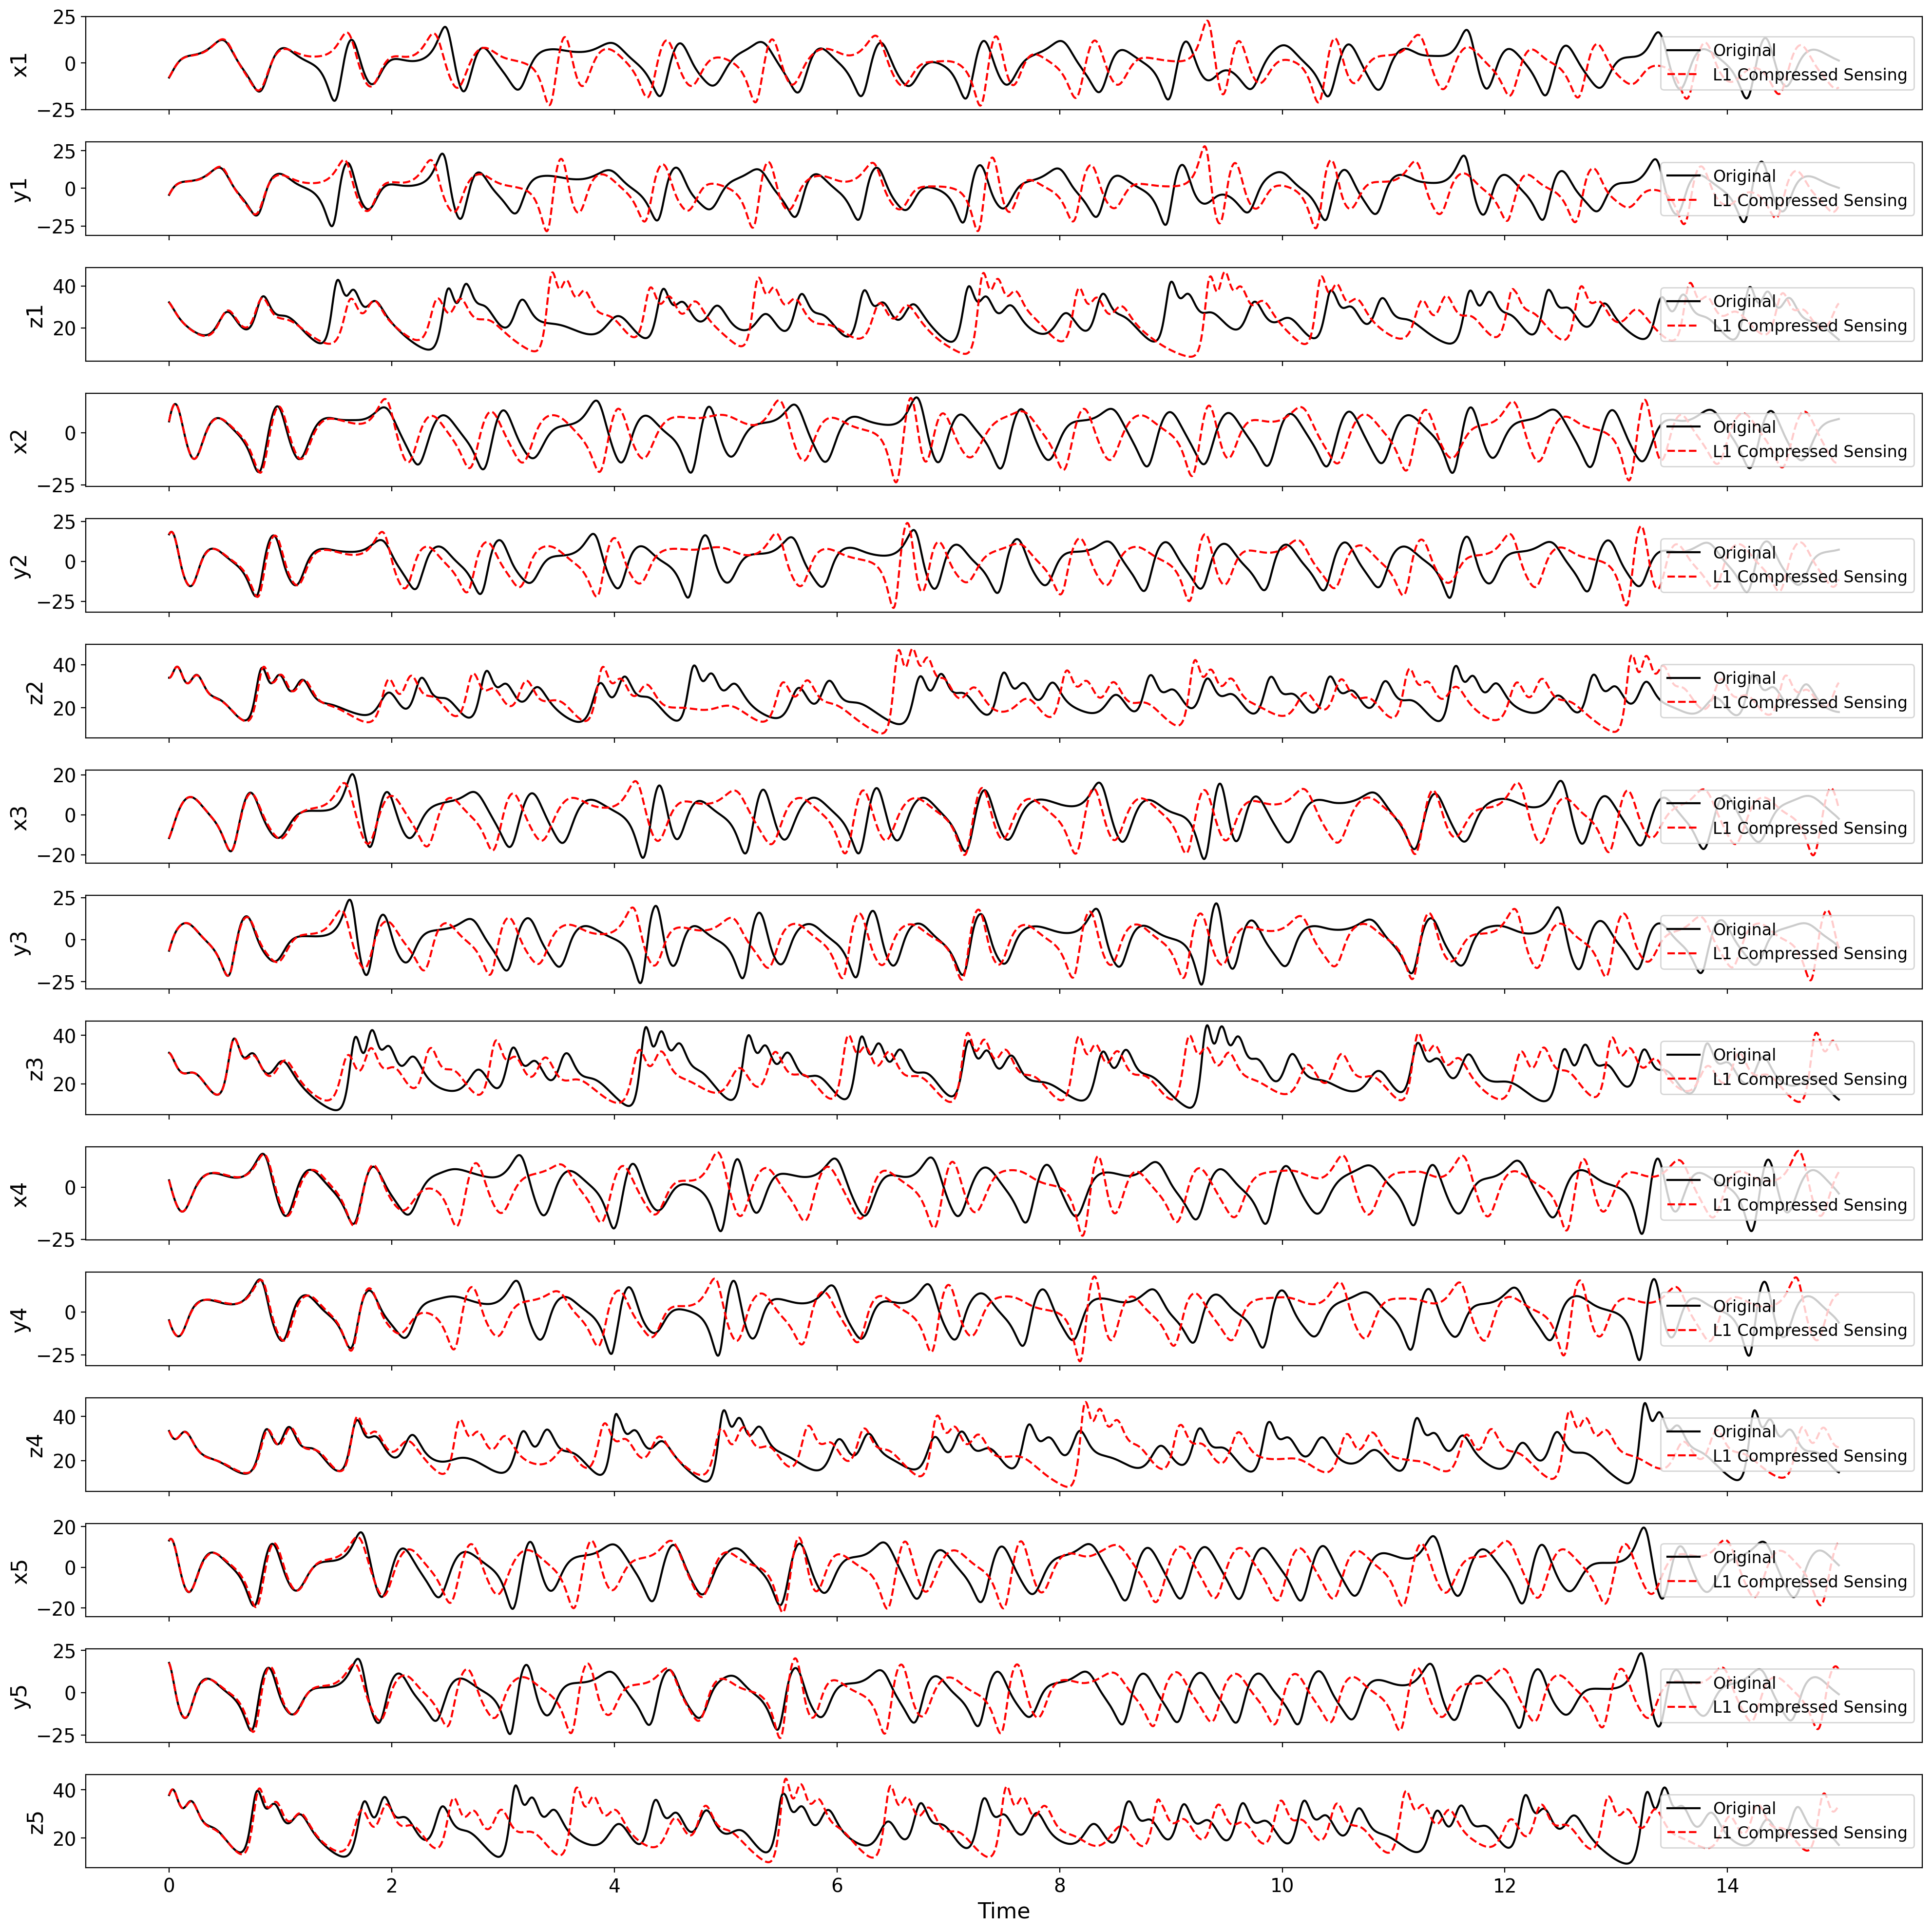

In [26]:
# Simulate reconstructed system
def simulate(coeffs, initial, t_eval):
    def model(t, state):
        return build_library(state.reshape(1, -1)) @ coeffs
    sol = solve_ivp(model, (t_eval[0], t_eval[-1]), initial, t_eval=t_eval)
    return sol.y.T

init_state = X[0,:]
t_eval = t
X_rec = simulate(coeffs, init_state, t_eval)


# Plot comparison
fig, axes = plt.subplots(15, 1, figsize=(20, 20), sharex=True)
variables = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3',
            'x4', 'y4', 'z4', 'x5', 'y5', 'z5']

for i, var in enumerate(variables):
    axes[i].plot(t_eval, X[:, i], 'k-', label='Original')
    axes[i].plot(t_eval, X_rec[:, i], 'r--', label='L1 Compressed Sensing')
    axes[i].set_ylabel(var)
    axes[i].legend(loc='right')

axes[14].set_xlabel('Time')
plt.tight_layout()
plt.show()

Although the two systems do not match exactly, the structures are similar, which means our equation does work! Therefore, our interacting dynamical system should be:
$$
\begin{align}
\dot{x_i} &= -ax_i + ay_i + \alpha \sum_{j=1}^{5} A_{ij}(x_j-x_i)\\
\dot{y_i} &= -x_i z_i + cy_i + x_i + u\\
\dot{z_i} & = x_i y_i -bz_i + d
\end{align}
$$
where $a\approx 25$ (read from coefficient of y in each equation), $b\approx 3$ (read from $z_2/dt$), $c\approx 21$ (read from all equations), $d \approx 0.5$ (read from $dz_2/dt$ and $dz_3/dt$, $u\approx -14$ (read from $dy_5/dt$, $dy_3/dt$ and $dy_2/dt$)and `coupling strength` $\alpha\approx 0.5$. 

Now, we can also read off the network topology from the equation. If there is a connection between two points $i$ and $j$, there should be one additional $x_j$ term in $dx_i/dt$ and $x_i$ term in $dx_j/dt$. The adjacency matrix for the topology is:
$$\begin{pmatrix} 0 & 1 & 1 & 1 & 0 \\ 1 & 0 & 0 & 0 & 0 \\ 1 & 0 & 0 & 0 & 0 \\ 1 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 1 & 0 \end{pmatrix}$$